# Siamese Networks for Authorship Verification

Siamese Networks were first used decades ago for Signature Verification, and with the new interest in neural networks and deep learning, they are more recently being used for all kinds of verification tasks. Instead of teaching the network to recognise examples of a specific class by giving it lots of labeled examples of that specific class, you instead have it learn a distance function between pairs of examples. It learns to tell if two examples are from the same class or from different classes.

For example, image re-identification is used for automatic access control. A single photo of a Alice as a reference or ID photo. When Alice wants to access the building, a new photo is taken at the door and compared to her reference photo. The door opens if the algorithm detects a match. With a simple classification neural net, we'd need to show the net many examples of Alice, in different poses, wearing different clothing, with her face at different angles. A siamese network can detect Alice even if has never seen her before. Instead of learning what Alice looks like, it learns to tell whether to photos are of the same person by learning a distance function between pairs of photos.

We show here how a Siamese Network can be used for authorship verification -- given two texts, it predicts whether or not they are written by the same author, even if has never seen other texts by that author.

Most of the code for the Siamese Network comes from here: https://github.com/fchollet/keras/blob/master/examples/mnist_siamese_graph.py

In [53]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, f1_score
from statistics import mean

In [54]:
# PATH CONFIG
datadir = "/data/panstuffs/"
pan15train = "pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "pan15-authorship-verification-test-dataset2-english-2015-04-19/"
pan14traine = "pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14teste = "pan14-author-verification-test-corpus2-english-essays-2014-04-22/"
pan14trainn = "pan14-author-verification-training-corpus-english-novels-2014-04-22/"
pan14testn = "pan14-author-verification-test-corpus2-english-novels-2014-04-22/"

In [55]:
def read_file(filepath):
    with open(filepath) as f:
        s = f.read()
    return s

class TextPair:
    def __init__(self, author, known, unknown, max_length=1200):
        self.author = author
        self.known = known
        self.unknown = unknown
        self.max_length = max_length

def get_string(filename):
    with open(filename, encoding="utf8") as f:
        s = f.read()
    return s

def get_texts(directory):
    authors = [x for x in os.listdir(directory) if x.startswith("EN")]
    tps = []
    for author in authors:
        known = os.path.join(directory, author, "known01.txt")
        unknown = os.path.join(directory, author, "unknown.txt")
        tps.append(TextPair(author, get_string(known), get_string(unknown)))
    return tps

def load_pan_data(directory):
    """Load known and unknown texts in the PAN data format"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory) if os.path.isdir(os.path.join(directory, x))])
    known_texts = []
    unknown_texts = []
    for author in authors:
        kfs = os.listdir(os.path.join(directory, author))
        kfs = [os.path.join(directory, author, x) for x in kfs if x.startswith("known")]
        all_known = ""
        for kf in kfs:
            one_kf = read_file(kf)
            all_known += "\n{}\n".format(one_kf)
        known_texts.append(all_known)
        
        uf = os.path.join(directory, author, "unknown.txt")
        unknown_texts.append(read_file(uf))
        
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    return known_texts, unknown_texts, y

In [56]:
# Vectorizing
def get_fit_vectorizer(texts):
    """Fit a Tfidf vectorizer on character and word n-grams"""
    char_tf = TfidfVectorizer(analyzer='char', ngram_range=(2,4), min_df=3)
    word_tf = TfidfVectorizer(ngram_range=(1,2), min_df=3)
    vec = FeatureUnion([
        ('char', char_tf),
        ('word', word_tf)
    ])
    vec.fit(texts)
    return vec

def vectorize_and_pair(knowntexts, unknowntexts, vectorizer):
    """Vectorize texts with a pre-fitted vectorizer"""
    known_X = vectorizer.transform(knowntexts).todense()  # dense arrays are inefficient but easier to work with
    unknown_X = vectorizer.transform(unknowntexts).todense()
    pairs = create_pairs(known_X, unknown_X)
    pairs = pairs.squeeze()  # TODO: why do we pick up an extra dimension?
    return pairs

In [57]:
%%time
tr_known, tr_unknown, tr_labels = load_pan_data(datadir + pan15train)
te_known, te_unknown, te_labels = load_pan_data(datadir + pan15test)

# - or uncomment to run on novels from 2014 -- still do OK, but not great
# p15train_known, p15train_unknown, p15train_labels = load_pan_data(pan14train)
# p15test_known, p15test_unknown, p15test_labels = load_pan_data(pan14test)

# - or on essays from '14 -- worse than guessing performance
# p15train_known, p15train_unknown, p15train_labels = load_pan_data(pan14train_e)
# p15test_known, p15test_unknown, p15test_labels = load_pan_data(pan14test_e)

# - fit the vectorizer on the training data (known and unknown texts)
# vectorizer = get_fit_vectorizer(p15train_known + p15train_unknown)

# - tranform the texts into pairs of vectors
# train_pairs = vectorize_and_pair(p15train_known, p15train_unknown, vectorizer)
# test_pairs = vectorize_and_pair(p15test_known, p15test_unknown, vectorizer)

CPU times: user 91.9 ms, sys: 99.9 ms, total: 192 ms
Wall time: 374 ms


In [58]:
%%time
vectorizer = get_fit_vectorizer(tr_known + tr_unknown)
train_pairs = vectorize_and_pair(tr_known, tr_unknown, vectorizer)
test_pairs = vectorize_and_pair(te_known, te_unknown, vectorizer)

CPU times: user 10.6 s, sys: 574 ms, total: 11.2 s
Wall time: 11.4 s


In [59]:
train_pairs.shape

(100, 2, 29317)

In [73]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    # The number and size of layers is not that important
    # Dropout has a big (negative?) effect
    seq = Sequential()
    seq.add(Dense(256, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(256, activation='relu'))      
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    return seq

def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

def train_network(train_pairs, train_labels, epochs=20):
    input_dim = train_pairs.shape[-1]

    # network definition
    base_network = create_base_network(input_dim)

    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    # we re-use the same `base_network` - weights will be shared across the branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    
    # batch size is very sensitive
    rms = RMSprop()
    model.compile(loss=contrastive_loss, optimizer=rms)
    model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
              batch_size=10,
              epochs=epochs, verbose=0)
    return model

def evaluate(test_pairs, test_y, model, threshold=0.5):
    """Predict and Evaluate for a test set"""
    predicted_distances = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
    predictions = [1 if p[0] <= threshold else 0 for p in predicted_distances]  # close to zero is a small distance and therefore 'same' prediction
    print(Counter(predictions))  # useful for balanced datasets -- we can see if we need to adjust threshold
    print(classification_report(test_y, predictions))
    print("Accuracy {}".format(accuracy_score(test_y, predictions)))
    same_fscore = f1_score(test_y, predictions, pos_label=1)
    diff_fscore = f1_score(test_y, predictions, pos_label=0)
    avg_fscore = mean([same_fscore, diff_fscore])
    return predicted_distances



## Training and Testing

We attempt the original task (train on 100 pairs and test on 500) as well as the reverse (train on 500 and test on 100.) Results are a bit variable, but should be 75-80 for test and ~85-90 for train. Delete `verbose=0` above if you want to see the training progress -- training should only take a couple of minutes though.

In [74]:
# The original PAN 15 task -- train on 100 example pairs and test on 500
model = train(train_pairs, tr_labels, 5)
distances = evaluate(test_pairs, te_labels, model)

# The reverse is interesting too, especially as the data is quite different (see distance plots below)
# Train on 500 and test on 100
model2 = train(test_pairs, te_labels, 5)
distances2 = evaluate(train_pairs, tr_labels, model2)

Epoch 1/5
100/100 [==============================] - 3s - loss: 0.3079     
Epoch 2/5
100/100 [==============================] - 2s - loss: 0.1336     

## Tuning precision and recall
Because we learned a distance function, the further the two pairs are from each other, the more confident we are that they're a different author. Therefore, we can use a low threshold for a high precision on same-author (we only predict that two texts are by the same author if the predicted distance is very small) or a high threshold for a high precision on different-author. Below we should get ~0.95 precision on 1 (same author) and then ~0.96 on 0, while keeping recall reasonable.

In [75]:
_ = evaluate(test_pairs, te_labels, model, 0.2)

Counter({0: 267, 1: 233})
             precision    recall  f1-score   support

          0       0.72      0.77      0.74       250
          1       0.75      0.70      0.72       250

avg / total       0.74      0.73      0.73       500

Accuracy 0.734


In [76]:
_ = evaluate(test_pairs, te_labels, model, 0.7)

Counter({1: 456, 0: 44})
             precision    recall  f1-score   support

          0       1.00      0.18      0.30       250
          1       0.55      1.00      0.71       250

avg / total       0.77      0.59      0.50       500

Accuracy 0.588


## Visually comparing our learned distance function to a standard one

We can see that our distance function represents authorship style by comparing it to euclidean distance. Note that in some cases (i.e., the test dataset) a simple distance function provide an above-guessing baseline.

In [141]:
from scipy.spatial.distance import euclidean, cosine
%matplotlib inline
from matplotlib import pyplot as plt

def plot_texts_by_distance(pairs, labels):
    dists = [euclidean(pairs[i][0], pairs[i][1]) for i in range(len(pairs))]
    same = [x for i, x in enumerate(dists) if labels[i]]
    diff = [x for i, x in enumerate(dists) if not labels[i]]
    plt.scatter(range(len(same)), same)
    plt.scatter(range(len(diff)), diff)
    plt.legend(["Same Author", "Different Author"])
    plt.xlabel("Text pairs")
    plt.ylabel("Euclidean Distance")
    return plt

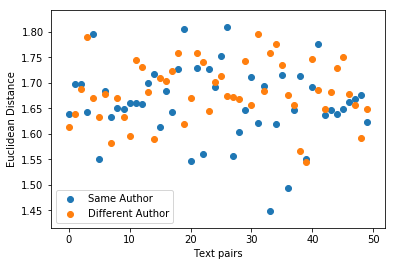

In [142]:
# The training data using euclidean distance
p = plot_texts_by_distance(train_pairs, tr_labels)
p.savefig("/tmp/train_euc.png", dpi=300)

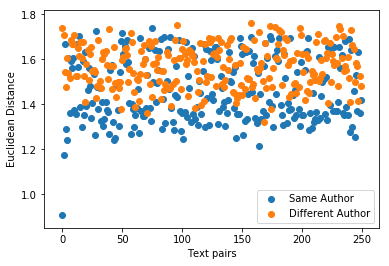

In [143]:
# The test data using euclidean distance
p = plot_texts_by_distance(test_pairs, te_labels)
p.savefig("/tmp/test_euc.png", dpi=300)

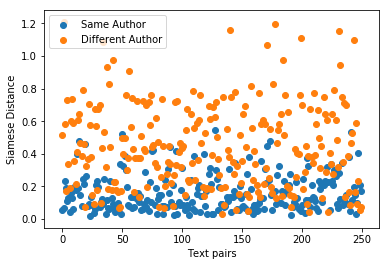

In [147]:
dists = distances
same = [x for i, x in enumerate(dists) if te_labels[i]]
diff = [x for i, x in enumerate(dists) if not te_labels[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(diff)), diff)
plt.legend(["Same Author", "Different Author"])
plt.xlabel("Text pairs")
plt.ylabel("Siamese Distance")
plt.savefig("/tmp/test_siam.png", dpi=300)

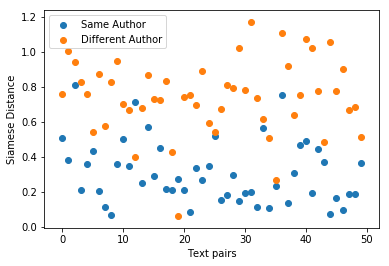

In [146]:
dists = distances2
same = [x for i, x in enumerate(dists) if tr_labels[i]]
diff = [x for i, x in enumerate(dists) if not tr_labels[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(diff)), diff)
plt.legend(["Same Author", "Different Author"])
plt.xlabel("Text pairs")
plt.ylabel("Siamese Distance")
plt.savefig("/tmp/train_siam.png", dpi=300)

In [407]:
def load_C50_identification(directory):
    """Concatenate everything we know about an author to identify new texts"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory)])
    texts = []
    for author in authors:
        authordir = os.path.join(directory, author)
        authortexts = os.listdir(authordir)
        concatenated_text = ""  # all the text from one author
        for textfile in authortexts:
            with open(os.path.join(directory, author, textfile)) as f:
                s = f.read()
            texts.append(s)
    return texts, authors

In [408]:
def load_C50_test(directory):
    """Concatenate everything we know about an author to identify new texts"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory)])
    texts = []
    for author in authors:
        authordir = os.path.join(directory, author)
        authortexts = os.listdir(authordir)
        for textfile in authortexts:
            with open(os.path.join(directory, author, textfile)) as f:
                s = f.read()
            texts.append(s)
    return texts, authors

In [294]:
all_training_texts, authors = load_C50_identification("/data/c50/C50train/")

In [274]:
with open("/data/c50/C50test/AaronPressman/43033newsML.txt") as f:
    s = f.read()
unknowns = [s for _ in range(50)]

In [207]:
test_texts, authors = load_C50_test("/data/c50/C50test/")

In [210]:
test_labels = []
for i in range(50):
    test_labels += [i] * 25

In [281]:
len(all_training_texts)

2500

In [296]:
known_vecs = vectorizer.transform(all_training_texts)
known_vecs = known_vecs.todense()

In [295]:
all_training_texts[2]

'Elementary school students with access to the Internet learned more than kids who lacked access, an indepedent research group concluded after conducting a comparative study in seven urban school districts.\n"This study dramatically illustrates the positive effects of online use on learning," said Michael Casserly, executive director of the Council of Great City Schools, an association of 49 large inner city public school districts which co-sponsored the study along with Scholastic Corp.\n'

In [308]:
text = test_texts[1]
t = [text for _ in range(2500)]
tv = vectorizer.transform(t)
tv = tv.todense()
pairs = create_pairs(known_vecs, tv)
pairs = pairs.squeeze()

predicted_distances = model.predict([pairs[:, 0], pairs[:, 1]])
closest = np.argmin(predicted_distances)
actual = predicted_distances[0]
print(closest, predicted_distances[closest], actual)

36 [ 0.01244664] [ 0.49105215]


In [309]:
sdists = sorted([(predicted_distances[i], i) for i in range(2500)])

In [310]:
sdists[:25]

[(array([ 0.01244664], dtype=float32), 36),
 (array([ 0.01286823], dtype=float32), 131),
 (array([ 0.01291359], dtype=float32), 216),
 (array([ 0.01309486], dtype=float32), 90),
 (array([ 0.01400337], dtype=float32), 93),
 (array([ 0.01484404], dtype=float32), 76),
 (array([ 0.01508458], dtype=float32), 974),
 (array([ 0.01530687], dtype=float32), 95),
 (array([ 0.0156406], dtype=float32), 936),
 (array([ 0.01762168], dtype=float32), 132),
 (array([ 0.01766282], dtype=float32), 54),
 (array([ 0.01863556], dtype=float32), 873),
 (array([ 0.01960699], dtype=float32), 402),
 (array([ 0.0196489], dtype=float32), 805),
 (array([ 0.01984583], dtype=float32), 866),
 (array([ 0.02002442], dtype=float32), 829),
 (array([ 0.02096993], dtype=float32), 1165),
 (array([ 0.02117799], dtype=float32), 51),
 (array([ 0.02153324], dtype=float32), 94),
 (array([ 0.0218785], dtype=float32), 110),
 (array([ 0.02268427], dtype=float32), 1167),
 (array([ 0.02304309], dtype=float32), 55),
 (array([ 0.02340996

In [311]:
test_texts[1]

'Two members of Congress criticised the Federal Reserve Thursday for what they called its "woefully inadequate" record of hiring and promoting women and minorities.\nRepresentative Henry Gonzalez and Representative Jesse Jackson Jr., in a letter to Fed chairman Alan Greenspan, said several discrimination lawsuits against the bank "show a clear need for reform."\nThe letter paired persistent Fed critic Gonzalez, a Democrat from Texas serving his 19th term in Congress, with second-term Illinois Democrat Jackson, son of the well-known civil rights leader.\nA Fed spokesman declined comment.\nOne of the lawsuits, filed against the central bank in January by four black secretaries, may be expanded as 15 other current and former employees have asked to join the litigation, the two Democratic lawmakers said.\n"As one of the nation\'s primary banking regulators, the Federal Reserve should serve as a model for the banking system it regulates," the two wrote to Greenspan.\n"Despite being at the f

In [313]:
all_training_texts[36]

'An influential economic research group is preparing guidelines on computer encryption for its member countries but will duck some of the most contentious issues involved, according to a draft obtained by Reuters.\nThe Clinton administration, seeking to rally support for its controversial policy on exporting encryption products -- which encode and decode e-mail and other computerized messages -- failed to win an endorsement from the Organisation for Economic Cooperation and Development (OECD), although the group did discuss the administration\'s approach.\nOn perhaps the most difficult issue, the draft guidelines do not favour or oppose a requirement in the U.S. policy that data-scrambling encryption programmes provide a way for law enforcement officials to obtain keys to crack the codes when necessary.\nAfter indicating that governments should carefully weigh the costs and benefits of imposing so-called key recovery, the draft report said, "this principle should not be interpreted as 

Counter({0: 35, 1: 15})


In [ ]:
predictions = [1 if p[0] <= 0.20 else 0 for p in predicted_distances]  # close to zero is a small distance and therefore 'same' prediction
print(Counter(predictions))  # useful for balanced datasets -- we can see if we need to adjust threshold

In [203]:
predictions

[1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

In [335]:
def load_C50_identification(directory):
    """Concatenate everything we know about an author to identify new texts"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory)])
    texts = []
    for author in authors:
        authortexts = []
        authordir = os.path.join(directory, author)
        authorfiles= os.listdir(authordir)
        concatenated_text = ""  # all the text from one author
        for textfile in authorfiles:
            with open(os.path.join(directory, author, textfile)) as f:
                s = f.read()
            authortexts.append(s)
        texts.append(authortexts)
    return texts, authors

In [366]:
from random import shuffle
authors, _ = load_C50_identification("/data/C50/C50train/")
allknowns = []
allunknowns = []
for i, authortexts in enumerate(authors):
    # Take the first 20 texts of the author as 'known texts'. The next 10 as postive 'unknown' samples.
    knowns = authortexts[:20]
    unknowns = authortexts[20:30]
    
    # select 15 other authors at random
    other_authors = list(range(50))
    del other_authors[i]
    shuffle(other_authors)
    other_authors = other_authors[:10]
    for oa in other_authors:
        oatexts = authors[oa]
        unknowns.append(oatexts[-1])
        del(oatexts[-1])
    allknowns += knowns[:]
    allunknowns += unknowns[:]
    
print(len(allknowns))
print(len(allunknowns))

counter_knowns = Counter(allknowns)
counter_unknowns = Counter(allunknowns)

print(all([x == 1 for x in counter_knowns.values()]))  # no duplicates in knowns
print(all([x == 1 for x in counter_unknowns.values()])) # no duplicates in unknowns
print(set(Counter(allunknowns).keys()).intersection(set(Counter(allknowns).keys()))) # knowns/unknowns don't share 

1000
1000
True
True
set()


In [373]:
labels = [1] * 10 + [0] * 10

In [375]:
labels *= 50

In [377]:
Counter(labels)

Counter({0: 500, 1: 500})

In [381]:
labels[0] = 1

In [382]:
Counter(labels)

Counter({0: 500, 1: 500})

<IPython.core.display.Javascript object>


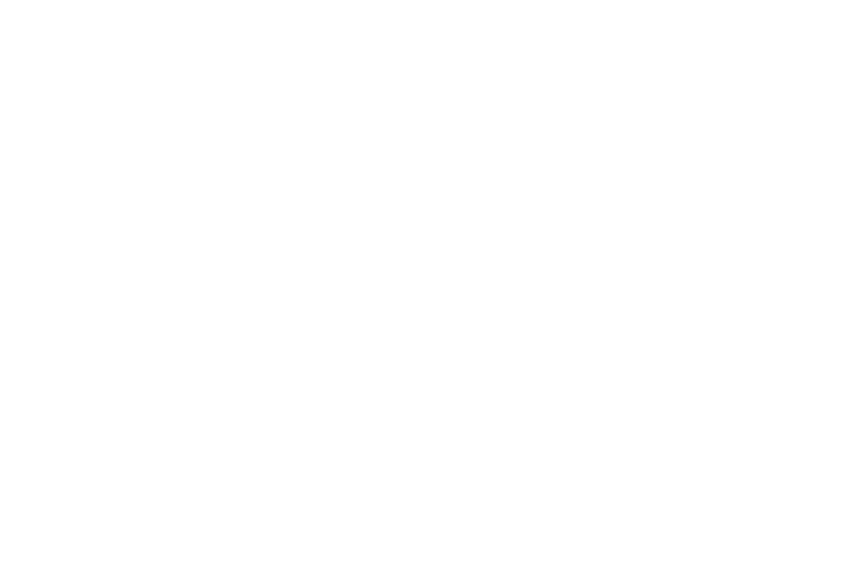

<IPython.core.display.Javascript object>


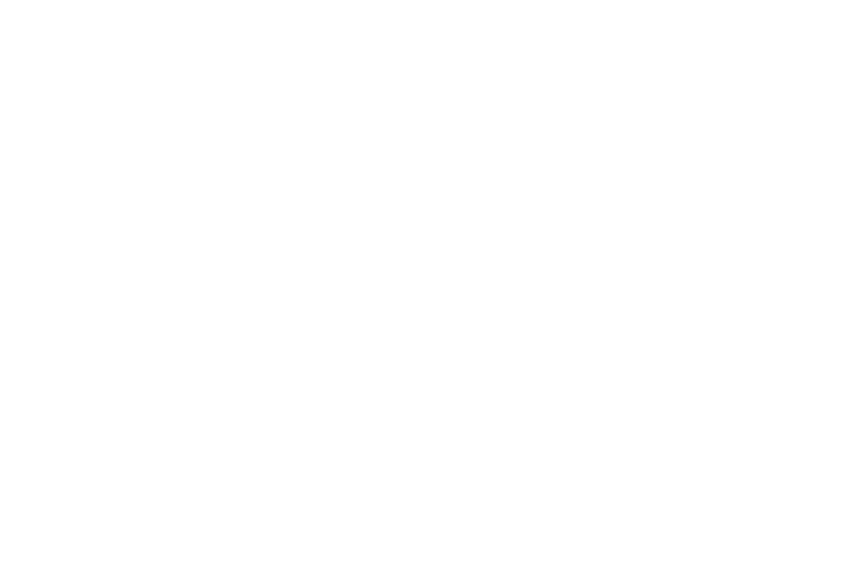

In [108]:
plt.plot([1,2,3])
plt.show()